In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

## qc

In [25]:
ds0 = xr.open_dataset('/portal1/dell/li-b/NDVI/MOD13A1.061_500m_aid0001.nc')
ds0

<xarray.Dataset>
Dimensions:                          (time: 6, lat: 2281, lon: 2761)
Coordinates:
  * time                             (time) object 2022-09-30 00:00:00 ... 20...
  * lat                              (lat) float64 34.0 34.0 ... 24.51 24.5
  * lon                              (lon) float64 110.5 110.5 ... 122.0 122.0
Data variables:
    crs                              int8 ...
    _500m_16_days_EVI                (time, lat, lon) float32 ...
    _500m_16_days_NDVI               (time, lat, lon) float32 ...
    _500m_16_days_pixel_reliability  (time, lat, lon) float64 ...
    _500m_16_days_VI_Quality         (time, lat, lon) float64 ...
Attributes:
    title:        MOD13A1.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.43.1
    references:   See README.md
    history:      See README.md

In [36]:
vari = ds0['_500m_16_days_NDVI'].to_dataset()
vari

<xarray.Dataset>
Dimensions:             (time: 6, lat: 2281, lon: 2761)
Coordinates:
  * time                (time) object 2022-09-30 00:00:00 ... 2022-12-19 00:0...
  * lat                 (lat) float64 34.0 34.0 33.99 33.99 ... 24.51 24.51 24.5
  * lon                 (lon) float64 110.5 110.5 110.5 ... 122.0 122.0 122.0
Data variables:
    _500m_16_days_NDVI  (time, lat, lon) float32 ...

In [27]:
qc = ds0['_500m_16_days_pixel_reliability'].to_dataset()
qc

<xarray.Dataset>
Dimensions:                          (time: 6, lat: 2281, lon: 2761)
Coordinates:
  * time                             (time) object 2022-09-30 00:00:00 ... 20...
  * lat                              (lat) float64 34.0 34.0 ... 24.51 24.5
  * lon                              (lon) float64 110.5 110.5 ... 122.0 122.0
Data variables:
    _500m_16_days_pixel_reliability  (time, lat, lon) float64 ...

In [37]:
times = vari.time.values
x = vari.dims['lon']
y = vari.dims['lat']

In [29]:
times[1:6]

array([cftime.DatetimeJulian(2022, 10, 16, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2022, 11, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2022, 11, 17, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2022, 12, 3, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2022, 12, 19, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)

In [38]:
vari0 = vari.sel(lon=vari.lon.values, lat=vari.lat.values, time = times[1:6])['_500m_16_days_NDVI'].to_dataset(name='vari')

qc0 = qc.sel(lon=vari.lon.values, lat=vari.lat.values, time = times[1:6])['_500m_16_days_pixel_reliability'].to_dataset(name='qc')


In [39]:
arr_s0 = np.zeros(((1,y,x)))

for t in times[1:6]:
    print(t, end='\r')
    qc_a = qc0.sel(time=t).qc.values
    
    
    qc_b = np.zeros((y, x), dtype=bool)
    
    #qc_b = (np.bitwise_and(qc_a.astype(np.uint8), 0b11100000) != 128) & (np.bitwise_and(qc_a.astype(np.uint8), 0b00011000) != 8)
    #qc_b = np.bitwise_and(qc_a.astype(np.uint8), 0b00011000) != 8
    qc_b = np.where((qc_a==0) | (qc_a==1), True, False)

    
    vari_a = vari0.sel(time=t).vari.values
    vari_b = np.zeros((y, x))

    vari_b = np.where(qc_b & (vari_a>=-1), vari_a, np.nan)

              
    vari_c = vari_b.reshape(1,y,x)
    
    arr_s0 = np.append(arr_s0,vari_c,axis=0)
    
    
arr_s1 = arr_s0[1:,:,:]

In [40]:
dsvari1 = xr.Dataset({'vari': (['time','lat','lon'], arr_s1)},
                    coords={ 'time': (['time'], times[1:6]),
                            'lat': (['lat'], vari.lat.values),
                            'lon': (['lon'], vari.lon.values),})
dsvari1.to_netcdf('/portal1/dell/li-b/NDVI/ndvi2022_qc1.nc')

In [43]:
ds1 = xr.open_dataset('/portal1/dell/li-b/NDVI/evi2022_qc0.nc')
ds2 = xr.open_dataset('/portal1/dell/li-b/NDVI/evi2022_qc1.nc')
ds = xr.concat([ds1,ds2],dim='time')
ds

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:  (time: 23, lat: 2281, lon: 2761)
Coordinates:
  * time     (time) object 2022-01-01 00:00:00 ... 2022-12-19 00:00:00
  * lat      (lat) float64 34.0 34.0 33.99 33.99 ... 24.51 24.51 24.51 24.5
  * lon      (lon) float64 110.5 110.5 110.5 110.5 ... 122.0 122.0 122.0 122.0
Data variables:
    vari     (time, lat, lon) float64 0.2054 0.2087 0.2317 ... nan nan nan

In [42]:
ds.to_netcdf('/portal1/dell/li-b/NDVI/evi2022_qc.nc')

## ndvi

In [2]:
ds0 = xr.open_dataset('/portal1/dell/li-b/NDVI/ndvi_m_qc_0.05.nc')

# exclude taiwan(120.5,122)(24.5,25.5) 
arr = ds0['vari'].values.copy()
arr[:,169:,200:] = np.nan
ds00 = xr.Dataset({'vari': (['time','lat','lon'], arr)},
                      coords={'time': (['time'], ds0.time.values), 
                              'lat': (['lat'], ds0.lat.values),
                      'lon': (['lon'], ds0.lon.values),})

ds1 = ds00

In [2]:
ds1 = xr.open_dataset('/portal1/dell/li-b/multiregression/ndvi1.nc')

In [3]:
def cal_month_ano_aver(ds1, mon):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon]))
    ds_m = ds_m0['vari'].values

    anos = np.zeros_like(ds_m)

    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(2002,2023)
            
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing':
                    pvalue=1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='decreasing':
                    pvalue=-1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='no trend':
                    pvalue=np.nan
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
                
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], ds_m0.time.values), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [4]:
def cal_3month_ano_aver(ds1, mon1, mon2, mon3):
    ds_m0 = ds1.sel(time=ds1['time.month'].isin([mon1, mon2, mon3]))
    ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
    ds_m = ds_m1['vari'].values

    anos = np.zeros_like(ds_m)

    for i in range(0,ds_m.shape[2]):
        for j in range(0,ds_m.shape[1]):
            v1 = ds_m[:,j,i]
            date = np.arange(2002,2023)
            
            non_nan_count = np.count_nonzero(~np.isnan(v1))
            if non_nan_count > 1:
                tr = mk(v1, alpha=0.05).trend
                if tr=='increasing':
                    pvalue=1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='decreasing':
                    pvalue=-1
                    slo = stats.linregress(date,v1).slope
                    interc = stats.linregress(date,v1).intercept
                    trend = slo*date + interc
                    anos[:,j,i] = v1 - trend
                elif tr=='no trend':
                    pvalue=np.nan
                    anos[:,j,i] = v1 - v1.mean()
            else:
                anos[:,j,i] = v1 - v1.mean()
                
    ds_ano = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                        coords={'time': (['time'], ds_ano7.time.values), 
                                'lat': (['lat'], ds_m0.lat.values),
                        'lon': (['lon'], ds_m0.lon.values),})
    return ds_ano

In [5]:
ds_ano7 = cal_month_ano_aver(ds1, 7)
ds_ano8 = cal_month_ano_aver(ds1, 8)
ds_ano9 = cal_month_ano_aver(ds1, 9)
ds_ano789 = cal_3month_ano_aver(ds1, 7, 8, 9)

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [16]:
ds_ano789.to_netcdf('/portal1/dell/li-b/multiregression/ndvi.nc')

In [6]:
c7 = ds_ano7['vari'].mean(dim=['lat','lon'],skipna=True).values
c8 = ds_ano8['vari'].mean(dim=['lat','lon'],skipna=True).values
c9 = ds_ano9['vari'].mean(dim=['lat','lon'],skipna=True).values
c789 = ds_ano789['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2002','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'jul_ano':c7,'agu_ano':c8,'sep_ano':c9,'jas_ano':c789})
df1

,time,jul_ano,agu_ano,sep_ano,jas_ano
0,2002-12-31,-0.004220,0.003121,-0.004626,-0.001081
1,2003-12-31,-0.024530,-0.028860,-0.018354,-0.023745
2,2004-12-31,-0.004774,-0.002840,-0.013650,-0.005867
3,2005-12-31,-0.002883,0.000169,-0.004544,-0.000618
4,2006-12-31,0.004840,0.003027,-0.016292,-0.001961
5,2007-12-31,0.005138,0.001305,0.004831,0.004020
6,2008-12-31,-0.000515,0.000085,0.002861,0.002242
7,2009-12-31,0.003013,0.009284,-0.005844,0.002802
8,2010-12-31,-0.001280,-0.000230,0.013517,0.004513
9,2011-12-31,-0.001687,0.007706,0.015781,0.009389


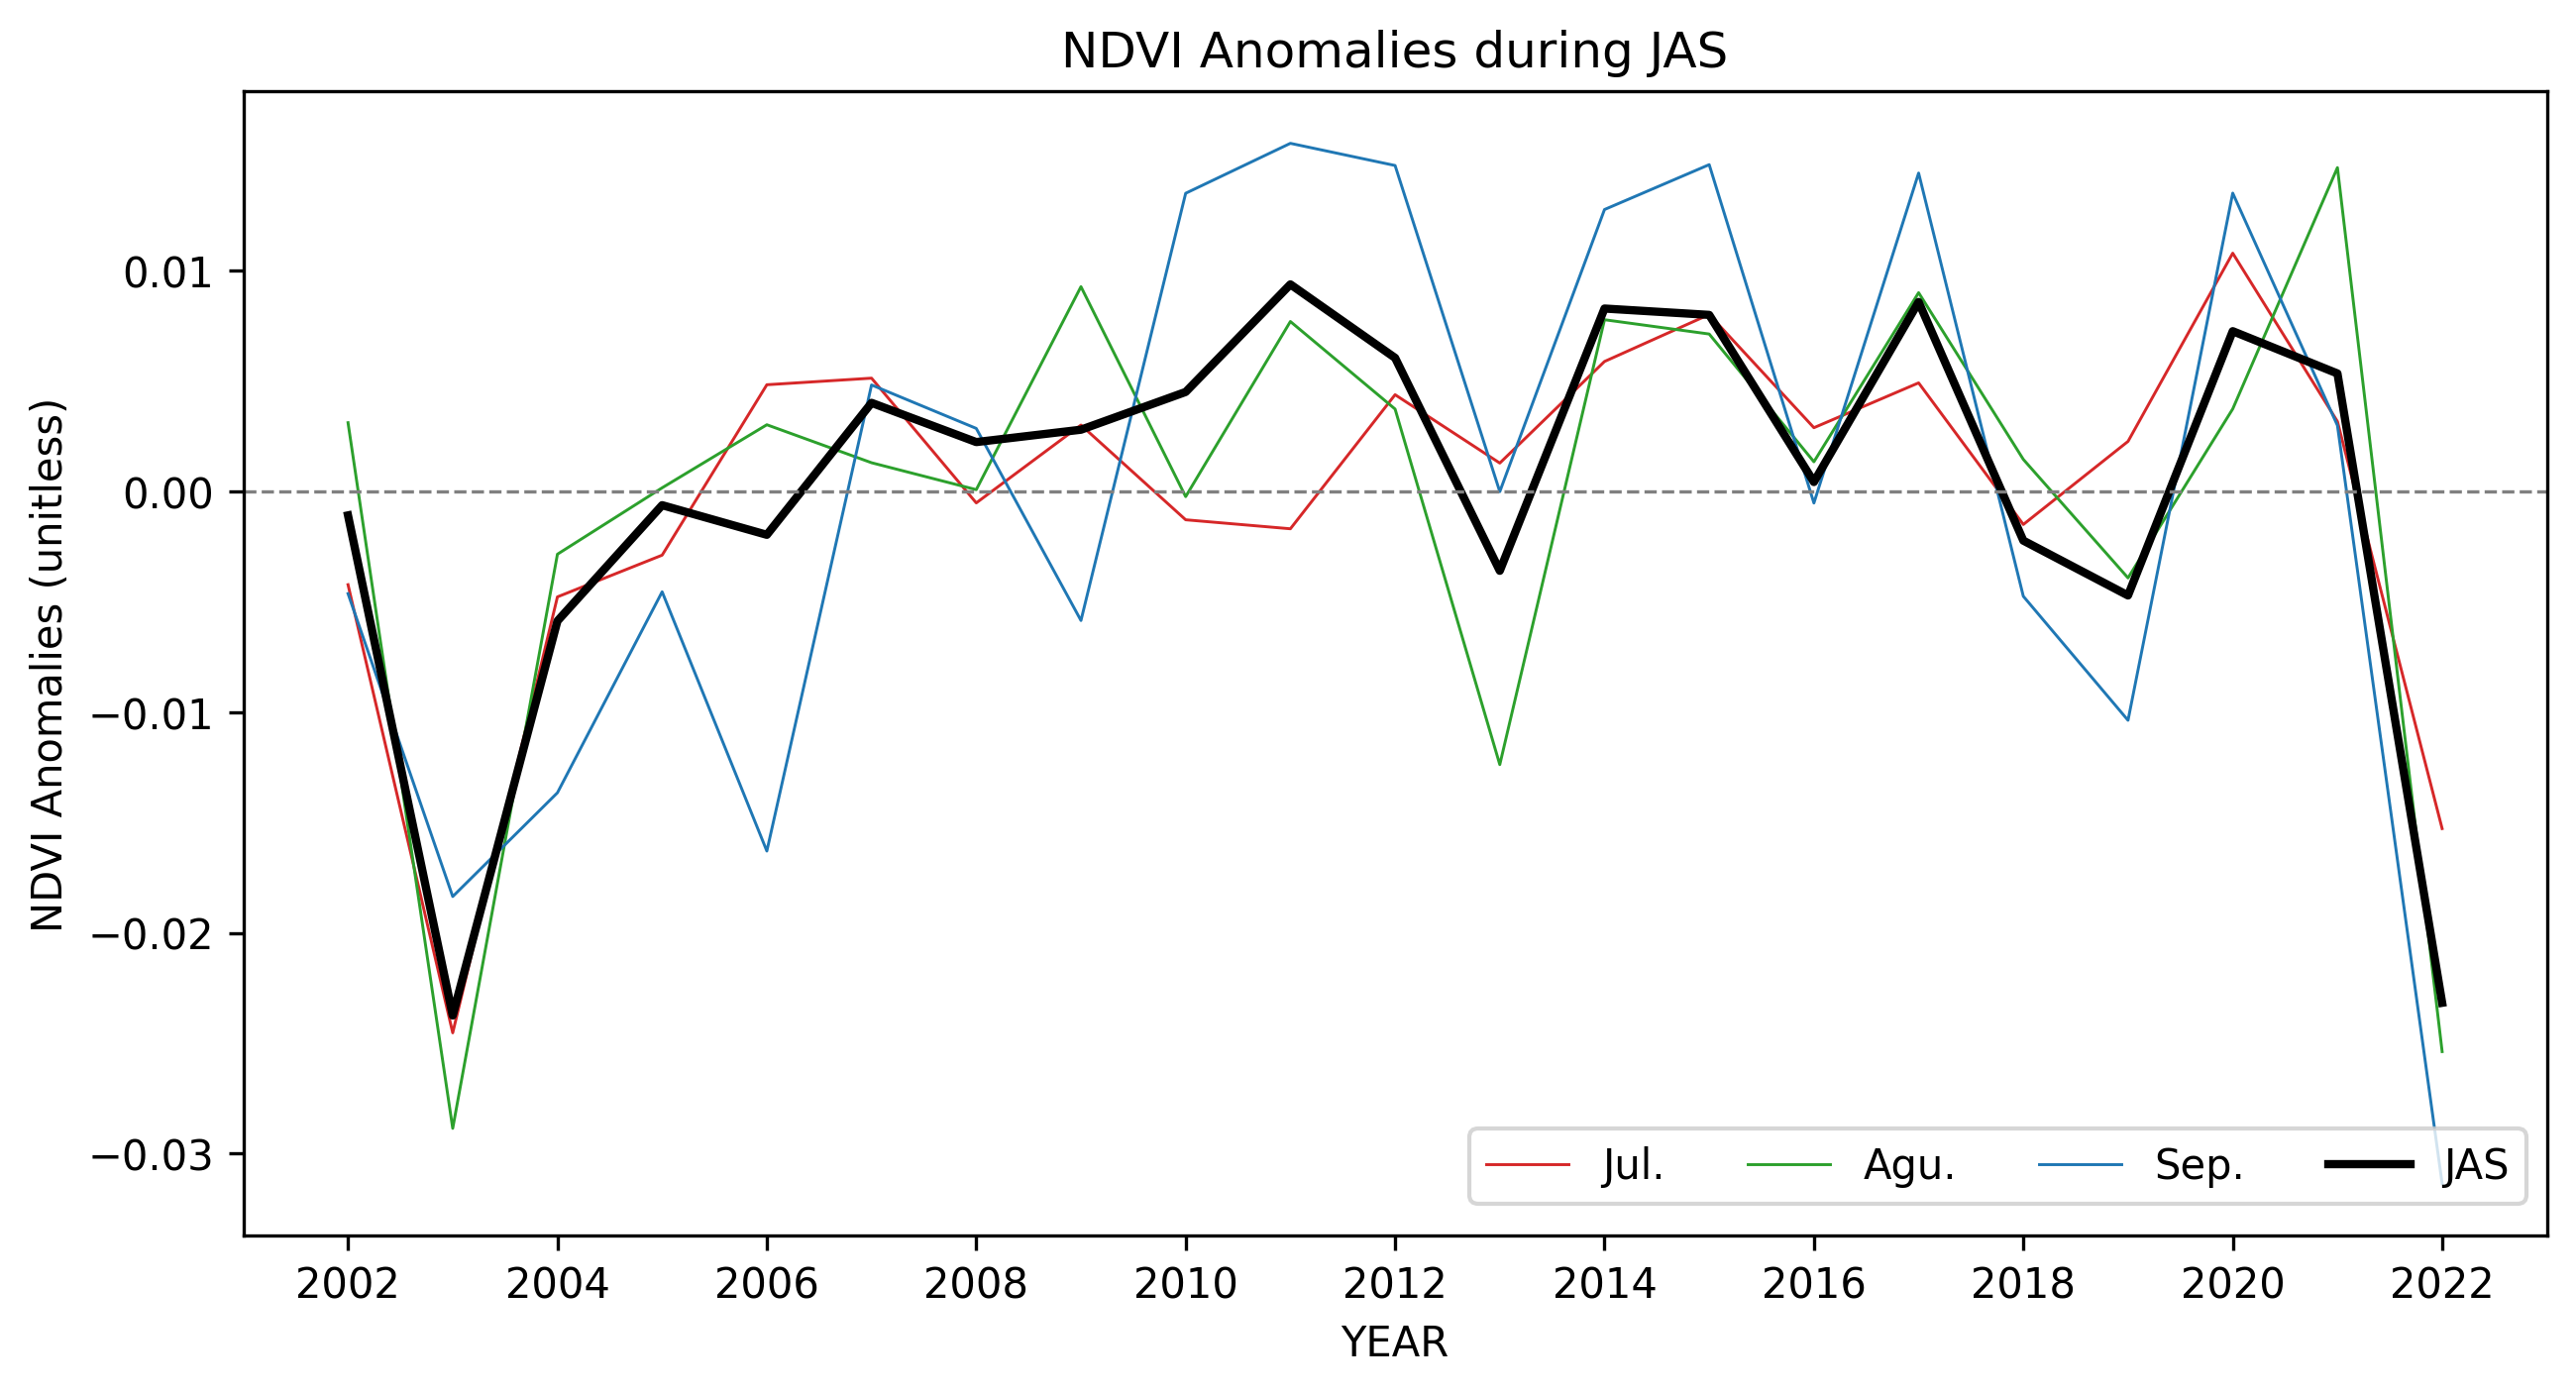

In [7]:
date = np.arange(2002,2023)
v1 = df1['jul_ano']
v2 = df1['agu_ano']
v3 = df1['sep_ano']
v4 = df1['jas_ano']

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))


ax.plot(date, v1,color='tab:red',lw=0.7, ls='-', label='Jul.')
ax.plot(date, v2,color='tab:green',lw=0.7, ls='-', label='Agu.')
ax.plot(date, v3,color='tab:blue',lw=0.7, ls='-', label='Sep.')
ax.plot(date, v4,color='black',lw=2, ls='-', label='JAS')

ax.set_ylabel('NDVI Anomalies (unitless)')
#ax1.set_ylabel('PRR (%)')
ax.set_xlabel('YEAR')
custom_ticks = np.arange(2002, 2023, step=2)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels

ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_tick_labels)

ax.axhline(y=0, color='gray', linestyle='--',lw=0.8)
    
#figname = filename.replace('.txt','')
ax.set_title('NDVI Anomalies during JAS')
ax.set_xlim(date[0]-1, date[-1]+1)
fig.legend(loc="lower right", bbox_to_anchor=(1, 0.01), bbox_transform=ax.transAxes, ncol = 5)

#plt.savefig('D:/rice/figs/middleyield.png')                         
plt.show()

In [10]:
d7_0 = ds_ano7['vari'].values
box7 = d7_0[~np.isnan(d7_0)].ravel()

d8_0 = ds_ano8['vari'].values
box8 = d8_0[~np.isnan(d8_0)].ravel()

d9_0 = ds_ano9['vari'].values
box9 = d9_0[~np.isnan(d9_0)].ravel()

d789_0 = ds_ano789['vari'].values
box789 = d789_0[~np.isnan(d789_0)].ravel()

box = [box7,box8,box9,box789]
for i in box:
    lo = np.nanpercentile(i,q=25)
    up = np.nanpercentile(i,q=75)
    upbo = up+1.5*(up-lo)
    lobo = lo-1.5*(up-lo)
    maxmum = i.max()
    minmum = i.min()
    print(upbo, lobo, maxmum, minmum)

0.08729007835956429 -0.08534382678784277 0.4223904900606487 -0.7279237948712934
0.0835128316245839 -0.08019102552508373 0.5397523758662017 -0.8881904454458129
0.08984569053757671 -0.0872407902306244 0.6917142491946247 -0.8979333213397355
0.07195443987499944 -0.07029018253296732 0.7988253604961486 -0.8489047378774309


/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Jul. NDVI Anomalies')

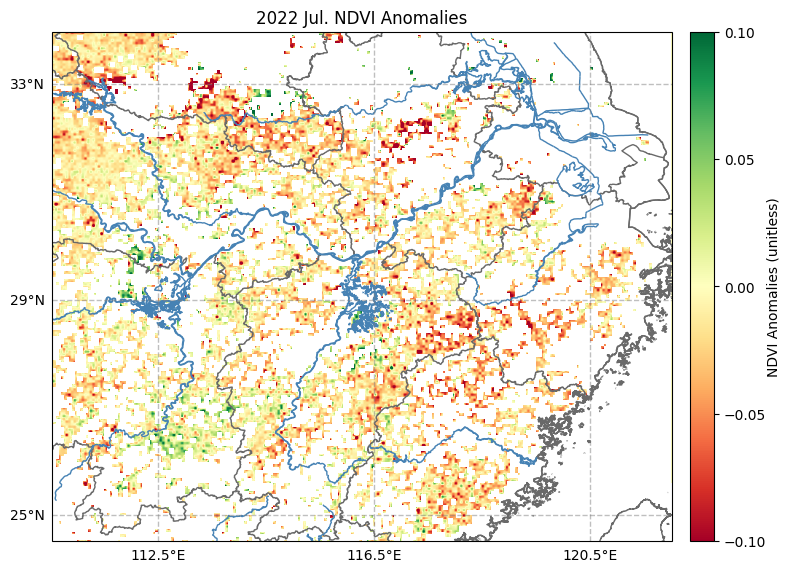

In [12]:
data = ds_ano7['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=0.1
vmin=-0.1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('NDVI Anomalies (unitless)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Jul. NDVI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Aug. NDVI Anomalies')

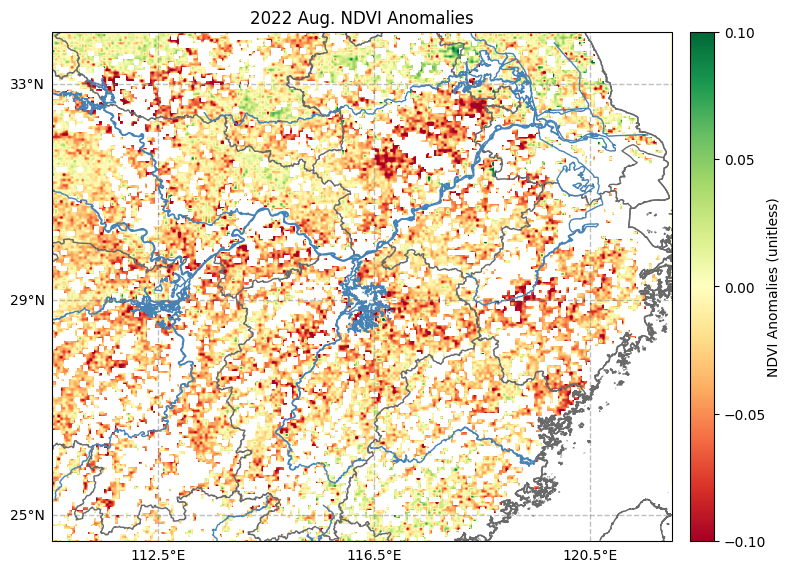

In [13]:
data = ds_ano8['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=0.1
vmin=-0.1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('NDVI Anomalies (unitless)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Aug. NDVI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Sep. NDVI Anomalies')

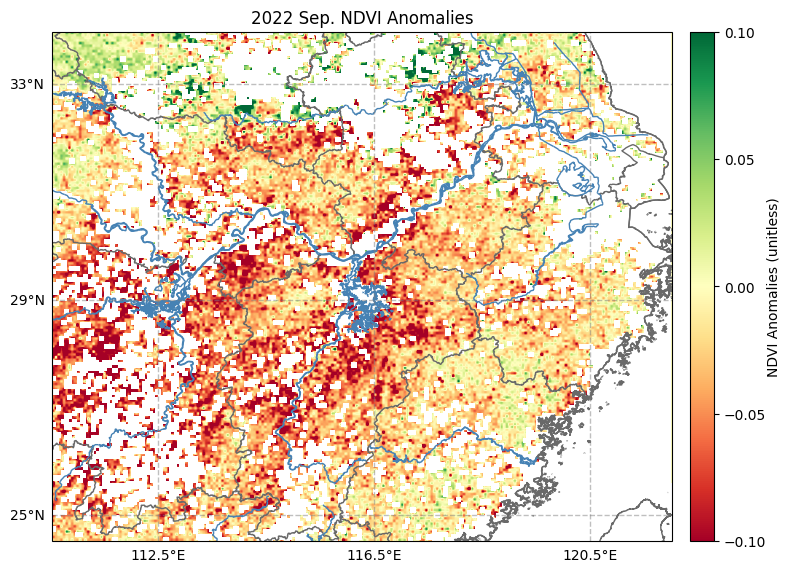

In [14]:
data = ds_ano9['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=0.1
vmin=-0.1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('NDVI Anomalies (unitless)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Sep. NDVI Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 JAS NDVI Anomalies')

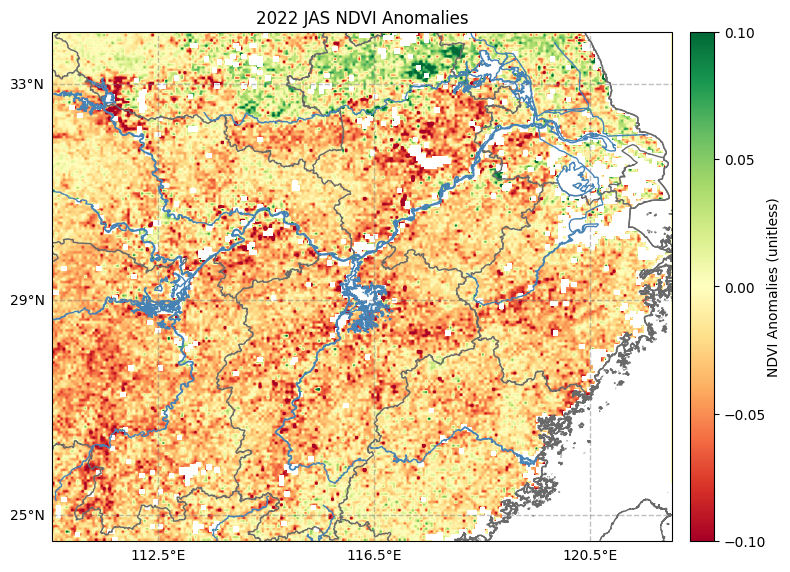

In [15]:
data = ds_ano789['vari'][20,:,:].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=0.1
vmin=-0.1
cmap = plt.get_cmap('RdYlGn')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('NDVI Anomalies (unitless)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 JAS NDVI Anomalies')

In [7]:
mask = xr.open_dataset('/portal1/dell/li-b/LC_IGBP_2022_epsg4326.tif')


x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']
qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a==1) | (qc_a == 2) | (qc_a == 4) | (qc_a == 5)
vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
array_1b = vari_b.ravel()
pv = stats.ttest_ind(array_1b[~np.isnan(array_1b)],0).pvalue
print('forest', np.nanmean(vari_b), pv)
ds_tree = xr.Dataset({'vari': (['lat','lon'], vari_b)},
                    coords={ 
                            'lat': (['lat'], ds_ano789.lat.values),
                            'lon': (['lon'], ds_ano789.lon.values),})


x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']
qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a == 12) | (qc_a == 14)
vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
pv = stats.ttest_ind(array_1b[~np.isnan(array_1b)],0).pvalue
print('crop', np.nanmean(vari_b), pv)
ds_crop = xr.Dataset({'vari': (['lat','lon'], vari_b)},
                    coords={ 
                            'lat': (['lat'], ds_ano789.lat.values),
                            'lon': (['lon'], ds_ano789.lon.values),})

forest -0.01719533139378088 0.4184230052953569
crop -0.01891688320264377 0.4184230052953569


In [8]:
def exclude_sichuan(ds_full):
    arr = ds_full['vari'].values.copy()
    arr[:80,:51] = np.nan
    ds_ex = xr.Dataset({'vari': (['lat','lon'], arr)},
                      coords={ 
                                'lat': (['lat'], ds_full.lat.values),
                        'lon': (['lon'], ds_full.lon.values),})
    return ds_ex

ds_tree1 = exclude_sichuan(ds_tree)
ds_crop1 = exclude_sichuan(ds_crop)

In [9]:
import pyhdf
from pyhdf.SD import SD, SDC  

f = SD('/portal1/dell/li-b/MCD12C1.A2022001.061.2023244164746.hdf', SDC.READ)
# f.datasets()
newlat = np.linspace(89.975, -89.975, 3600) ## care about the order of lat and lon
newlon = np.linspace(-179.975, 179.975, 7200)

varis = f.select('Land_Cover_Type_1_Percent')[:,:,1]
ds_per1 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,2]
ds_per2 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,4]
ds_per4 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,5]
ds_per5 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,12]
ds_per12 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,14]
ds_per14 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

arrl1 = ds_per1['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl2 = ds_per2['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl4 = ds_per4['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl5 = ds_per5['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl12 = ds_per12['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl14 = ds_per14['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values

arr_p = arrl1 + arrl2 + arrl4 + arrl5
arr_p1 = arrl12 + arrl14


dem = xr.open_dataset('/portal1/dell/li-b/dem0.05.nc')
dems = dem['vari'].sel(time='2022-12-31').values

In [13]:
from scipy.stats import mode

x_1d_data = arr_p1.ravel()
y_1d_data = dems.ravel()
vari_b = ds_crop['vari'].values
z_1d_data = vari_b.ravel()

x_1d = arr_p[~np.isnan(arr_p1)].ravel()
y_1d = dems[~np.isnan(dems)].ravel()
z_1d = vari_b[~np.isnan(vari_b)].ravel()

bins = 100
x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(1000, decimals=1), bins)
x_gap = (x.max()-x.min())/bins
y_gap = (y.max()-y.min())/bins
out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('dem',y),('veg',x)])

for i in range(bins):
    for j in range(bins):
        index = np.argwhere(
            (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
        ).ravel()
        sel = z_1d_data[index]
        if len(sel) == 0:
            out_2d_arr[i][j] = np.nan
        else:
            results = mode(sel)
            out_2d_arr[i][j] = results.mode

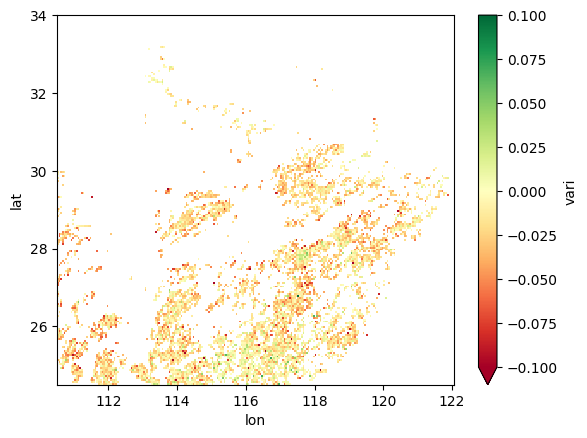

In [17]:
ds_tree1['vari'].plot(vmax=0.1,vmin=-0.1,cmap='RdYlGn')

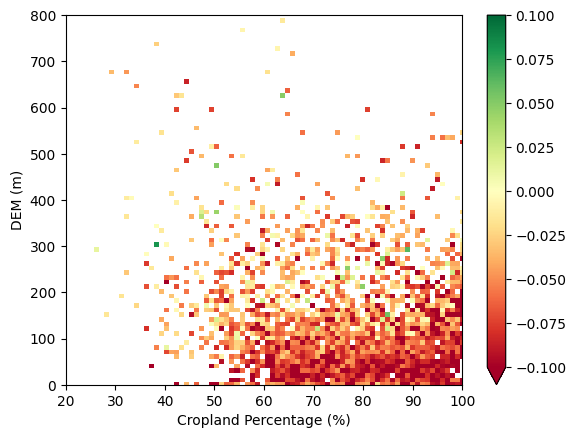

In [15]:
plot = out_2d_arr.plot(vmax=0.1, vmin=-0.1, cmap='RdYlGn')
ax = plot.axes

ax.set_xlim(20, 100)
ax.set_ylim(0,800)
ax.set_xlabel('Cropland Percentage (%)')
ax.set_ylabel('DEM (m)')
plt.show()

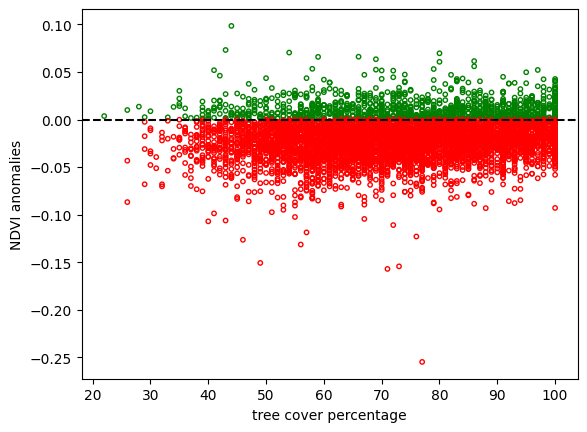

In [19]:
plt.scatter(x_1d_data[z_1d_data >= 0], z_1d_data[z_1d_data >= 0], s=10, facecolors='none', edgecolors='green')
plt.scatter(x_1d_data[z_1d_data < 0], z_1d_data[z_1d_data < 0], s=10, facecolors='none', edgecolors='red')
plt.xlabel('tree cover percentage')
plt.ylabel('NDVI anomalies')
plt.axhline(y=0, color='black', linestyle='--')

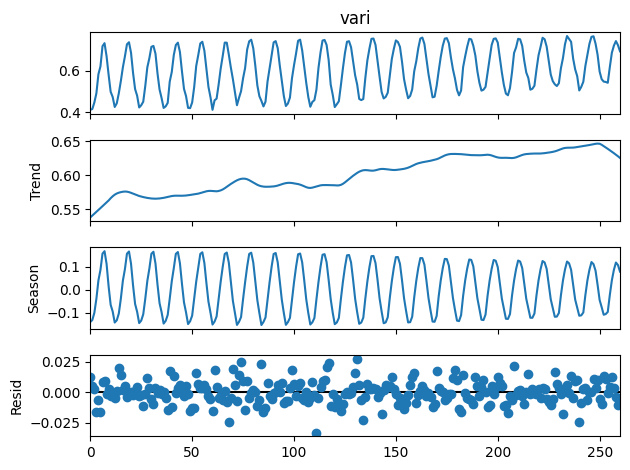

In [32]:
from statsmodels.tsa.seasonal import STL

stl = STL(df0['vari'], period=12, seasonal=13)
res = stl.fit()

fig = res.plot()

## lai

In [4]:
ds = xr.open_dataset('/portal1/dell/li-b/NDVI/lai_qc.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 941, lat: 2281, lon: 2761)
Coordinates:
  * time     (time) object 2002-07-04 00:00:00 ... 2022-12-27 00:00:00
  * lat      (lat) float64 34.0 34.0 33.99 33.99 ... 24.51 24.51 24.51 24.5
  * lon      (lon) float64 110.5 110.5 110.5 110.5 ... 122.0 122.0 122.0 122.0
Data variables:
    vari     (time, lat, lon) float64 ...

In [3]:
ds_jas = ds.sel(time=ds['time.month'].isin([7,8,9]))
ds_jas1 = ds_jas.groupby('time.year').mean(dim='time')

ds_jas_m = ds_jas1['vari'].mean(dim='year', skipna=True).to_dataset()
ds_jas_m1 = ds_jas_m['vari'].values.reshape(1,ds_jas_m.dims['lat'],ds_jas_m.dims['lon'])

ds_jas_ano = ds_jas1['vari'].values - ds_jas_m1

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [4]:
ds_jas_ano_detr = np.zeros((ds_jas1.dims['year'],ds_jas1.dims['lat'],ds_jas1.dims['lon']))

x = np.arange(2002,2023)

for la in range(0,ds_jas1.dims['lat']):
    for lo in range(0,ds_jas1.dims['lon']):
        y = ds_jas_ano[:,la,lo]
        annualmean_trend = stats.linregress(x, y)
        slope, intercept = annualmean_trend.slope, annualmean_trend.intercept
        trend = slope * x + intercept
        
        ds_jas_ano_detr[:,la,lo] = ds_jas_ano[:,la,lo] - trend

In [5]:
ds_ano = xr.Dataset({'vari': (['time','lat','lon'], ds_jas_ano_detr)},
                      coords={ 'time': (['time'], ds_jas1.year.values),
                              'lat': (['lat'], ds_jas1.lat.values),
                      'lon': (['lon'], ds_jas1.lon.values),})
ds_ano

<xarray.Dataset>
Dimensions:  (time: 21, lat: 2281, lon: 2761)
Coordinates:
  * time     (time) int64 2002 2003 2004 2005 2006 ... 2018 2019 2020 2021 2022
  * lat      (lat) float64 34.0 34.0 33.99 33.99 ... 24.51 24.51 24.51 24.5
  * lon      (lon) float64 110.5 110.5 110.5 110.5 ... 122.0 122.0 122.0 122.0
Data variables:
    vari     (time, lat, lon) float64 0.1421 -0.144 -0.1331 ... nan nan nan

In [37]:
ds_ano['vari'].sel(time=int(2022)).mean(dim=['lat','lon'], skipna=True).values

array(-0.02792482)

In [6]:
boxjas = ds_ano['vari'].sel(time=int(2022)).to_dataset().vari.values
boxjas1 = boxjas[~np.isnan(boxjas)].ravel()

lo = np.nanpercentile(boxjas1,q=25)
up = np.nanpercentile(boxjas1,q=75)
upbo = up+1.5*(up-lo)
lobo = lo-1.5*(up-lo)
upbo, lobo

(0.8817391861401077, -0.9492219163245169)

In [10]:
max = boxjas1.max()
min = boxjas1.min()
max, min

(4.201118328900202, -4.3860995449703415)

Text(0, 0.5, 'LAI Anomalies')

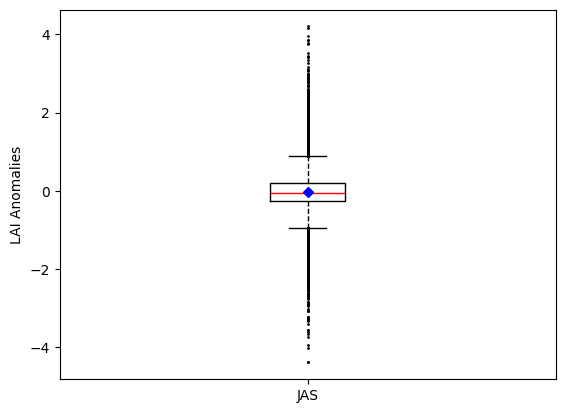

In [8]:
plt.boxplot(boxjas1,labels=['JAS'], sym='o', whis=1.5, meanline=False, showmeans=True, showcaps=True, showbox=True, showfliers=True,flierprops={'markerfacecolor':'black', 'markeredgecolor':'black', 'markersize':1}, medianprops={'linestyle':'-', 'color':'red'}, meanprops={'marker':'D', 'markerfacecolor':'blue', 'markersize':5,'markeredgecolor':'blue'}, boxprops={'color':'black'}, whiskerprops={'linestyle':'--', 'color':'black'})
plt.ylabel('LAI Anomalies')

Text(0, 0.5, 'LAI Anomalies')

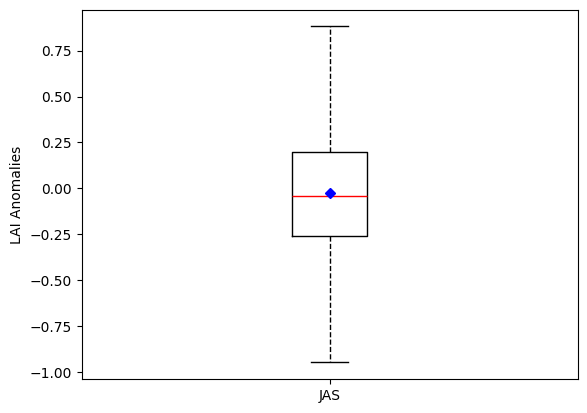

In [9]:
plt.boxplot(boxjas1,labels=['JAS'], sym='o', whis=1.5, meanline=False, showmeans=True, showcaps=True, showbox=True, showfliers=False, medianprops={'linestyle':'-', 'color':'red'}, meanprops={'marker':'D', 'markerfacecolor':'blue', 'markersize':5,'markeredgecolor':'blue'}, boxprops={'color':'black'}, whiskerprops={'linestyle':'--', 'color':'black'})
plt.ylabel('LAI Anomalies')

Text(0.5, 1.0, '2022 JAS LAI Anomalies')

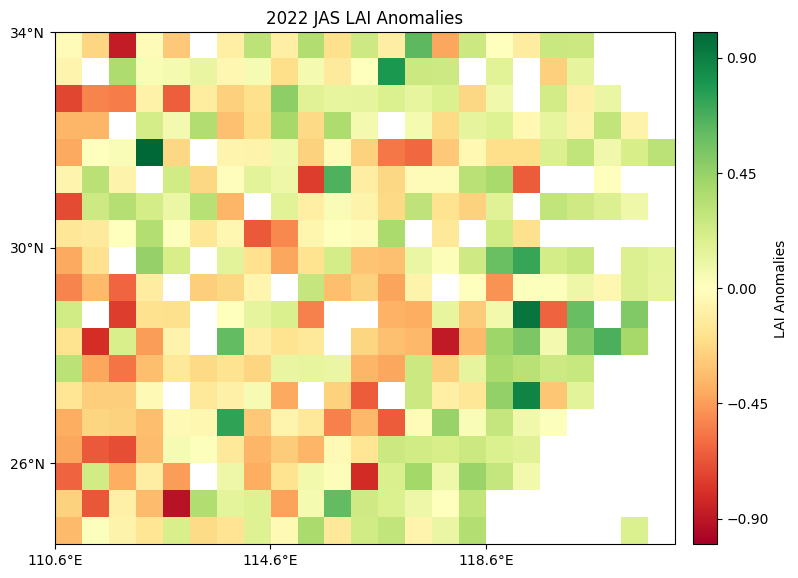

In [21]:
dd = ds_ano['vari'].sel(time=int(2022)).to_dataset()

lon = dd.lon.values
lat = dd.lat.values

dx = np.diff(lon).mean() / 2
dy = np.diff(lat).mean() / 2
extent = [max(np.min(lon) - dx, -179.99), 
          min(np.max(lon) + dx, 179.99), 
          max(np.min(lat) + dy, -89.99),
          min(np.max(lat) - dy, 89.99)]

data = dd.vari.values

cmap = plt.get_cmap('RdYlGn')

fig = plt.figure(figsize=(8, 10))

# Label axes of a Plate Carree projection with a central longitude of 180:
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
im = ax.imshow(data, extent=extent, cmap=cmap,transform=ccrs.PlateCarree())
vmin = -1
vmax = 1

im.set_clim(vmin=vmin, vmax=vmax)


ticks = list(np.linspace(vmin+0.1, vmax-0.1, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('LAI Anomalies')
cbar.set_ticks(ticks)


ax.set_xticks(np.arange(110.6, 122, 4), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(34, 24.5, -4), crs=ccrs.PlateCarree())
# ax.set_xticks(lon[::20], crs=ccrs.PlateCarree())
# ax.set_yticks(lat[::5], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.set_title('2022 JAS LAI Anomalies')

In [11]:
area = ds_jas1['vari'].mean(dim=['lon','lat'], skipna=True).to_dataset()

times = pd.date_range('2002-12-31', '2022-12-31', freq='Y')
varis = area['vari'].values
df = pd.DataFrame({'time':times,'vari':varis})
df.set_index('time', inplace=True)


<xarray.Dataset>
Dimensions:  (year: 21)
Coordinates:
  * year     (year) int64 2002 2003 2004 2005 2006 ... 2018 2019 2020 2021 2022
Data variables:
    vari     (year) float64 2.809 2.804 2.879 2.872 ... 3.136 2.974 3.122 3.128

In [13]:
date = np.arange(2002,2023)
v4 = df['vari'].values
slo = stats.mstats.linregress(date,v4).slope

tr = mk.original_test(v4, alpha=0.05).trend
if tr=='increasing':
    pvalue=1
if tr=='decreasing':
    pvalue=-1
if tr=='no trend':
    pvalue=np.nan   
    
slo, pvalue

(0.014797497960657945, 1)

In [14]:
# cal detrended jas ano from monthly series:
def calc_jas_ano(df0):
    # condition = np.isin(df0.index.month, [7, 8, 9])
    # df_jas0 = df0['vari'].where(condition, other=np.nan) 
    # df_jas1 = df_jas0.groupby(df_jas0.index.year).mean()
    annualmean = df0['vari'].mean()
    df_jas_ano = df0['vari'] - annualmean
    
    x = np.arange(2002,2023)
    annualmean_trend = stats.linregress(x, df_jas_ano.values)
    slope, intercept = annualmean_trend.slope, annualmean_trend.intercept
    trend = slope * x + intercept
    
    out_values = df_jas_ano - trend
    return out_values

In [15]:
v4 = calc_jas_ano(df).values
v4

array([-0.05089088, -0.07100306, -0.01019619, -0.03234364,  0.0303721 ,
        0.03720818,  0.02541456, -0.00819468,  0.03497511,  0.00893839,
        0.05046163,  0.08413819, -0.05167931, -0.00510107,  0.03852399,
        0.12012206, -0.02656686,  0.02452395, -0.15206646, -0.01876759,
       -0.02786841])

In [18]:
vv = v4.tolist()
vv

[-0.050890883101664564,
 -0.07100306253547384,
 -0.010196188235015224,
 -0.03234363519823269,
 0.03037209813916597,
 0.037208177604530324,
 0.0254145606736218,
 -0.008194675684364938,
 0.034975114260563434,
 0.008938389532113344,
 0.05046162550005562,
 0.08413818919166749,
 -0.05167931155196337,
 -0.005101073362192121,
 0.038523988551155686,
 0.12012206185246299,
 -0.026566861590481494,
 0.024523945467842534,
 -0.1520664566727299,
 -0.018767588040677907,
 -0.02786841480035429]

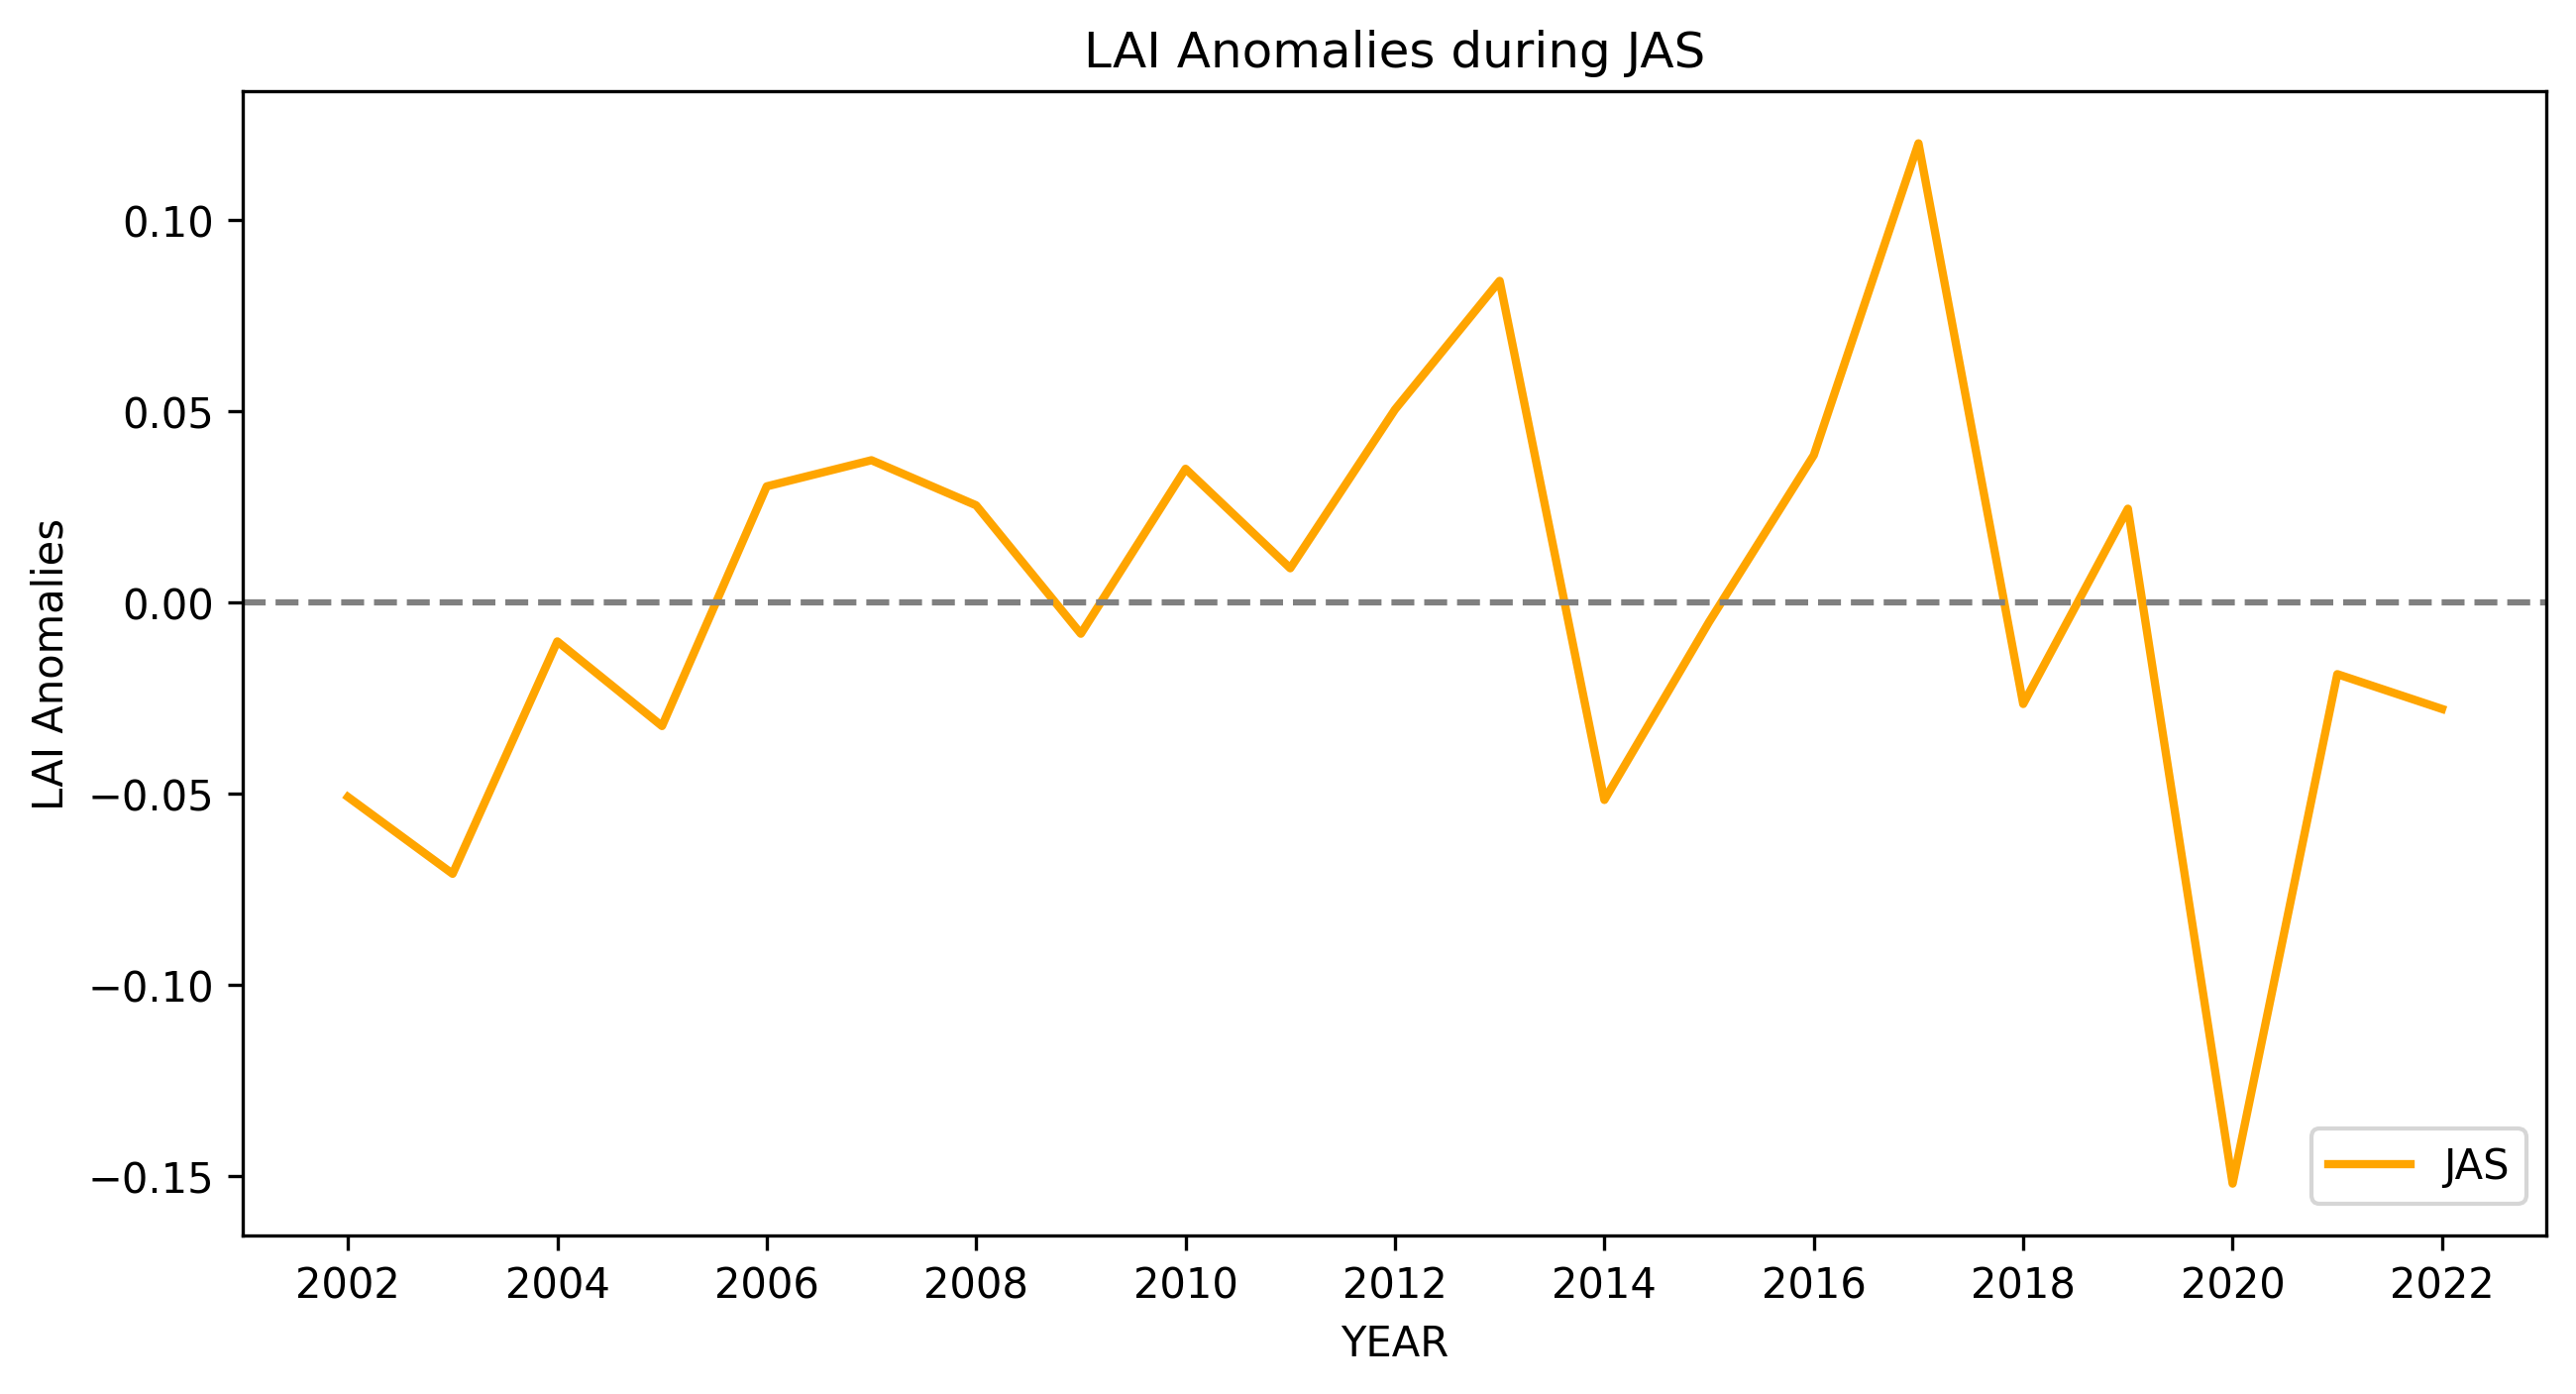

In [16]:
date = np.arange(2002,2023)
# v1 = df_7['ano']
# v2 = df_8['ano']
# v3 = df_9['ano']
v4

# v1 = df_7['ano']*31/8
# v2 = df_8['ano']*31/8
# v3 = df_9['ano']*30/8
# v4 = df_jas['ano']*92/8

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))



# colors = ['#0343DF' if v > 0 else 'orange' for v in v1]
# ax.bar(date, v1, width=0.5, linewidth=0.3, color='red', edgecolor='black', label='July')
# ax.bar(date, v2, width=0.5, linewidth=0.3, color='blue', edgecolor='black', label='Aguest')
# ax.bar(date, v3, width=0.5, linewidth=0.3, color='black', edgecolor='black', label='September')

# ax1 = ax.twinx()
# ax.plot(date, v1,color='red',lw=1, ls='-', label='Jul.')
# ax.plot(date, v2,color='blue',lw=1, ls='-', label='Agu.')
# ax.plot(date, v3,color='black',lw=1, ls='-', label='Sep.')
ax.plot(date, v4,color='orange',lw=2, ls='-', label='JAS')

ax.set_ylabel('LAI Anomalies')
#ax1.set_ylabel('PRR (%)')
ax.set_xlabel('YEAR')
custom_ticks = np.arange(2002, 2023, step=2)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels

ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_tick_labels)

ax.axhline(y=0, color='gray', linestyle='--')
    
#figname = filename.replace('.txt','')
ax.set_title('LAI Anomalies during JAS')
ax.set_xlim(date[0]-1, date[-1]+1)
fig.legend(loc="lower right", bbox_to_anchor=(1, 0.01), bbox_transform=ax.transAxes)

#plt.savefig('D:/rice/figs/middleyield.png')                         
plt.show()